In [1]:
from feos.si import *
from feos.dft import Pore3D, Adsorption3D, DFTSolver, FMTVersion, HelmholtzEnergyFunctional
from feos.pcsaft import PcSaftParameters

import pandas as pd
import numpy as np

from pymatgen.core import Structure
from pymatgen.analysis import structure_matcher

import matplotlib.pyplot as plt

/home/prehner/.conda/envs/feos/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/prehner/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")


In [2]:
structure = Structure.from_file('structure_parameters/ZIF-8.cif')
print('formula:  ', structure.formula)
print('num_sites:', structure.num_sites)

formula:   Zn12 H120 C96 N48
num_sites: 276


/home/prehner/.conda/envs/feos/lib/python3.9/site-packages/pymatgen/io/cif.py:669: UserWarning: A 1-line symmetry op P1 CIF is detected!
  warnings.warn(msg)
/home/prehner/.conda/envs/feos/lib/python3.9/site-packages/pymatgen/io/cif.py:1160: UserWarning: Issues encountered while parsing CIF: A 1-line symmetry op P1 CIF is detected!
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


In [3]:
coordinates = structure.cart_coords.T * ANGSTROM
system_size = [l * ANGSTROM for l in structure.lattice.lengths]

In [4]:
forcefield = pd.read_csv('structure_parameters/DREIDING.dat',delim_whitespace=True,names=["type","sigma","epsilon","mass"])
forcefield

type    sigma   epsilon      mass
0    O  3.03300   48.1581  15.99900
1    C  3.47299   47.8562  12.01070
2    H  2.84600    7.6489   1.00784
3    N  3.26250   38.9492  14.00670
4    B  3.58100   47.8059  10.81100
5   Zn  1.33000  109.4710  65.38000

In [5]:
sigma = np.zeros(structure.num_sites)
epsilon = np.zeros(structure.num_sites)

mass = 0.0

for i, site in enumerate(structure):
    sigma[i] = forcefield["sigma"][forcefield["type"]==site.species_string]
    epsilon[i] = forcefield["epsilon"][forcefield["type"]==site.species_string]
    mass = mass + float(forcefield["mass"][forcefield["type"]==site.species_string]) * 1.6605402E-27

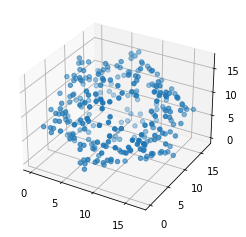

In [6]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=structure.cart_coords[:,0],ys=structure.cart_coords[:,1],zs=structure.cart_coords[:,2],s=20)

In [7]:
params = PcSaftParameters.from_json(['methane'], '../../parameters/pcsaft/gross2001.json')
func = HelmholtzEnergyFunctional.pcsaft(params, FMTVersion.AntiSymWhiteBear)

T = 303 * KELVIN

In [8]:
pore = Pore3D(system_size, [64, 64, 64], coordinates, sigma, epsilon)
pore.pore_volume

2.3689628728234253e-27 mÂ³

In [9]:
solver = DFTSolver().picard_iteration(beta=0.01,max_iter=50).picard_iteration(beta=0.1,tol=1.0e-5).anderson_mixing(mmax=10,tol=1.0e-8)
solver

|solver|log|max_iter|tol|beta|mmax|max_rel|
|-|:-:|-:|-:|-:|-:|-:|
|Picard Iteration||50|1e-11|0.01||1|
|Picard Iteration||500|1e-5|0.1||1|
|Anderson Mixing||150|1e-8|0.15|10||

In [10]:
%%time
isotherm = Adsorption3D.adsorption_isotherm(func, temperature = T, pressure = (100*PASCAL, 50*BAR, 20), pore=pore, solver=solver)

CPU times: user 17min 23s, sys: 2min 31s, total: 19min 55s
Wall time: 19min 47s


Text(0, 0.5, 'N')

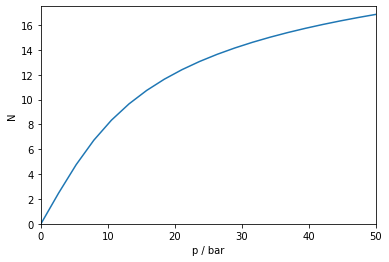

In [11]:
plt.plot(isotherm.pressure/BAR, isotherm.total_adsorption*NAV)
plt.axis([0,50,0,17.5])
plt.xlabel('p / bar')
plt.ylabel('N')